<a href="https://colab.research.google.com/github/Daniel022de/Bootcamp_SoulCode_EngenhariaDados/blob/main/ETL/etl_study_alesp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extração,transformação e carregamento de dados

Esse Notebook é referente as instruções feitas pelo professor **Igor Gondim** no bootcamp **engenharia de dados** da **SoulCode** nas aulas sobre o processo de extração,transformação,carregamento de dados e análise introdutória. Foi utilizado um dataset da Assembleia Legislativa de São Paulo **(ALESP)** disponível no Portal dos dados abertos e carregado no meu [Bucket Google Cloud](https://storage.googleapis.com/bucket-pratica-s3/ocorrencia%20(1).csv) para consolidar os conhecimentos.







! **Você pode encontrar esse notebook no meu repositório** [GitHub](https://github.com/Daniel022de/Bootcamp_SoulCode_EngenhariaDados)

! **Você pode entrar em contato comigo através do meu email** ddololiveira.pessoal@gmail.com **e** [Linkedin](https://www.linkedin.com/in/daniel-oliveira-503b0323b/).

! **Toda dúvida,recomendações e feedbacks serão bem-vindas.**



# **Instalações**

In [ ]:
pip install pandera

#**Bibliotecas**

In [2]:
import pandas as pd
import pandera as pa
import numpy as np

##**Set_Option**

In [3]:
pd.set_option('Display.max_columns',100)

#**Extração**

In [ ]:
df_desp = pd.read_csv("https://storage.googleapis.com/bucket-pratica-s3/alesp_desp.csv")

#**Pré-análise**

**Esse DataFrame contém despesas reembolsadas, agrupadas por tipo, por ano e por mês de despesa, e com os dados (nome e CNPJ) do fornecedor/favorecido.** 

**Ele reflete todos os gastos feitos pelos deputados na data de sua geração, podendo sofrer alterações no decorrer do ano fiscal vigente.**


Informações encontradas [aqui](https://www.al.sp.gov.br/dados-abertos/busca/despesa;jsessionid=2B5A10DA2A5AEF562870C8E5E3B87D10).


*situações verificadas na pré-análise:*

1.  **Unnamed: 0 - Dropar essa coluna. Diretriz passada em aula |>** OK
2.   **Posso unir as colunas 'ano' e 'mes' em uma só chamada 'data' |>** OK



In [5]:
df_desp.head(1)

,Unnamed: 0,Ano,Matricula,Mes,Valor,CNPJ,Deputado,Tipo,Fornecedor
0,0,2015,300257,3,200.0,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA


## Tipo das colunas



1.   **CNPJ precisa ser numérico!** **|>** OK

      Em cima de CNPJ não há cálculo a não ser validação,
      por isso dependendo do caso é melhor deixar object como está.
      Mas corrigido óbvio.
2.   



In [6]:
df_desp.dtypes

Unnamed: 0      int64
Ano             int64
Matricula       int64
Mes             int64
Valor         float64
CNPJ           object
Deputado       object
Tipo           object
Fornecedor     object
dtype: object

#**Tratamento | Limpeza de dados**

##Backup

In [7]:
dfback_desp = df_desp.copy()

##Renomeando colunas

In [8]:
df_desp.rename(columns= {'Ano':'ano','Matricula':'matricula','Mes':'mes','Valor':'valor','CNPJ':'cnpj','Deputado':'deputado','Tipo':'tipo','Fornecedor':'fornecedor'},inplace=True)

## Dropando coluna Unnamed: 0

In [9]:
df_desp.drop(['Unnamed: 0'],axis=1,inplace=True)

##Unindo colunas



*   As colunas 'ano' e 'mes' serão unidas.
*   



In [10]:
#Convertendo colunas para mesmo tipo

df_desp['ano'] = df_desp['ano'].astype(str)
df_desp['mes'] = df_desp['mes'].astype(str)

In [11]:
#Criando a coluna 'data'

df_desp['data'] = pd.to_datetime(df_desp['ano']+'-'+df_desp['mes']+'-'+'1')

## Dropando colunas 'ano' e 'mes'

In [12]:
df_desp.drop(['ano','mes'],axis=1,inplace=True)

## Coluna cnpj

* A coluna cnpj deve ser numérica. Há alguma inconsistência nos dados,pois 
a coluna está constando como object. Para desvendar o caso, vou realizar um teste de verificação e descobrir onde está as inconsistências.

* A coluna tem muito na. Então vou precisar fazer a verificação em cima de um DataFrame com os valores únicos da coluna cnpj.

In [13]:
# Verificando quantidade de nulos

df_desp.isna().sum()

matricula         0
valor             0
cnpj          10892
deputado          0
tipo              0
fornecedor        0
data              0
dtype: int64

In [14]:
# DataFrame somente com valores únicos da coluna cnpj
dfu = pd.DataFrame(df_desp.cnpj.unique(),columns = ['cnpj'])

In [15]:
dfu

,cnpj
0,71806251000106
1,68064740000125
2,22145388877
3,10915883000113
4,06222505000187
...,...
60228,43517978000138.0
60229,51667335000280.0
60230,50323741991.0
60231,6878968000100.0


In [16]:
#Verificação
lista_estranhos = []
for i in range(len(dfu)):
  try:
    int(dfu.loc[i,'cnpj'])
  except Exception:
    lista_estranhos.append(dfu.loc[i,'cnpj'])
print('Dados inconsistentes: ')
print(lista_estranhos)

Dados inconsistentes: 
[nan, 'O4689799000126', 'O4040553000129', 'O2358317000120', 'O1520430000105', '00O21449000136', 'O7482309000104']




*   Inconsistências encontradas:




1.   **Valores nan |>**
2.   **O no lugar de zero |>**







In [17]:
# Descobrindo os labels das inconsistências
filtro_i = df_desp.cnpj.isin(['O4689799000126', 'O4040553000129', 'O2358317000120', 'O1520430000105', '00O21449000136', 'O7482309000104'])
df_cnpj_i = df_desp.loc[filtro_i]
df_cnpj_i

,matricula,valor,cnpj,deputado,tipo,fornecedor,data
55891,300482,76.78,O4689799000126,ANTÔNIO CARLOS,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",VIA BARBARESCO LTDA,2007-11-01
55964,300482,70.02,O4040553000129,ANTÔNIO CARLOS,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO AUSTRIA LTDA,2008-02-01
55998,300482,50.00,O4040553000129,ANTÔNIO CARLOS,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO AUSTRIA LTDA,2008-03-01
316251,300455,40.00,O2358317000120,MARCOS MARTINS,"G - ASSINATURAS DE PERIÓDICOS, PUBLICAÇÕES, IN...",BASENET INFORMATICA LTDA,2007-09-01
365639,300468,504.12,O1520430000105,OLÍMPIO GOMES,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",PICANHARIA DO GAUCHO/ JOCELI NARDI CHURRASCARI...,2007-12-01
389510,300379,786.55,00O21449000136,PEDRO YVES,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO BOSQUE SATÉLITE LTDA,2002-05-01
389553,300379,915.76,00O21449000136,PEDRO YVES,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO BOSQUE SATÉLITE LTDA,2002-09-01
389565,300379,802.69,00O21449000136,PEDRO YVES,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO BOSQUE SATÉLITE LTDA,2002-10-01
389578,300379,3101.63,00O21449000136,PEDRO YVES,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO BOSQUE SATÉLITE LTDA,2002-12-01
389582,300379,5472.30,00O21449000136,PEDRO YVES,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO BOSQUE SATÉLITE LTDA,2003-01-01


In [18]:
# Replace nas inconsistências
df_desp.cnpj.replace('O','0',regex=True,inplace=True)

In [19]:
df_desp.loc[389510,'cnpj']

'00021449000136'

**Observação:**

Não é necessário converter a coluna 'cnpj' para int ou float. Por isso,corrigido as inconsistências, vou deixá-la como object para melhor manipulação dos dados.

###Filtros | Análises coluna cnpj

In [20]:
#Dados faltantes
ftnulos = df_desp.cnpj.isna()
dfnulo = df_desp.loc[ftnulos]
dfnulo

,matricula,valor,cnpj,deputado,tipo,fornecedor,data
787,300439,192.6,NaN,ADILSON BARROSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2003-03-01
814,300439,104.8,NaN,ADILSON BARROSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2003-04-01
852,300439,154.8,NaN,ADILSON BARROSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2003-05-01
877,300439,40.0,NaN,ADILSON BARROSO,K - LOCAÇÃO DE BENS MÓVEIS,TAXI,2003-05-01
892,300439,12.2,NaN,ADILSON BARROSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2003-06-01
...,...,...,...,...,...,...,...
536396,300441,80.6,NaN,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2006-10-01
536435,300441,19.7,NaN,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2006-11-01
536472,300441,63.2,NaN,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2006-12-01
536499,300441,14.6,NaN,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2007-01-01


####Deputados com mais cnpj nulos

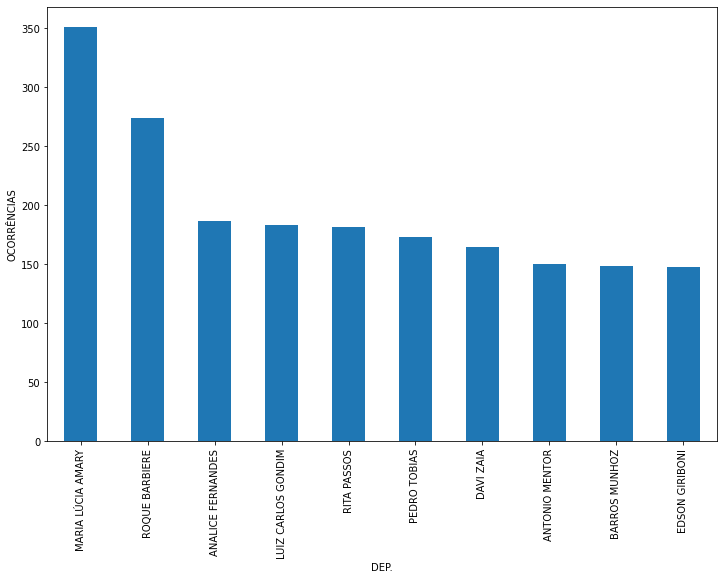

In [21]:
dfnulo.groupby(['deputado']).size().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8),xlabel='DEP.',ylabel='OCORRÊNCIAS',rot=90)

In [22]:
# Quantas vezes foi e o que foi que mais aparece cnpj nulo

dfnulo.groupby(['fornecedor']).size().sort_values(ascending=False)

fornecedor
PEDÁGIO                                           7476
TAXI                                              3385
PEDAGIO                                             11
ADOBE SYSTEMS SOFTWARE IRELAND LTDA                  5
PEDÁGIOS                                             2
GOOGLE ONE                                           2
ELOY DE PAULA JUNIOR                                 1
FLICKR, INC                                          1
DROPBOX INTERNACIONAL UNLIMETED COMPANY              1
GOOGLE STORAGE - GOOGLE ONE                          1
LEANDRO MATOS NICOLELA                               1
DELTA RADIO TAXI                                     1
PEDAGIOS                                             1
CUPONS DE PEDÁGIO                                    1
CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A.       1
PEGAGIO                                              1
ADOBE SYSTEMS SOFTWARE IRELAND LTD                   1
dtype: int64

In [23]:
# Quanto está sendo gasto em reais com cada 'produto'
valor = dfnulo.groupby('fornecedor').sum()
valor.head(2)

,matricula,valor
fornecedor,,
ADOBE SYSTEMS SOFTWARE IRELAND LTD,300470,124.0
ADOBE SYSTEMS SOFTWARE IRELAND LTDA,1502350,620.0


In [24]:
valor.valor.sort_values(ascending=False)

fornecedor
PEDÁGIO                                           1463663.60
TAXI                                               509931.22
ADOBE SYSTEMS SOFTWARE IRELAND LTDA                   620.00
PEDAGIO                                               539.10
DROPBOX INTERNACIONAL UNLIMETED COMPANY               495.42
GOOGLE ONE                                            349.98
FLICKR, INC                                           267.50
GOOGLE STORAGE - GOOGLE ONE                           174.99
CUPONS DE PEDÁGIO                                     125.20
ADOBE SYSTEMS SOFTWARE IRELAND LTD                    124.00
PEDÁGIOS                                               73.40
CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A.         65.20
PEDAGIOS                                               64.20
ELOY DE PAULA JUNIOR                                   62.00
LEANDRO MATOS NICOLELA                                 43.86
DELTA RADIO TAXI                                       42.00
PEGAGIO      

In [25]:
# Quanto foi gasto no total em relação a cnpj nulos
valor.valor.sum()

1976665.87

## Dados Pedágio



1.   **Inconsistência na palavra PEDÁGIO,PEDAGIO observada a partir de filtros realizados em cima do tipo C (MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE VEÍCULOS ; PEDÁGIOS)  |>** OK

**observação:** Essa inconsistência na palavra foi sinalizada em aula pelo professor, o desafio era encontrá-la e corrigir através de filtros.




In [26]:
df_desp.groupby(['tipo']).size()

tipo
A - COMBUSTÍVEIS E LUBRIFICANTES                                      142552
B - LOCAÇÃO E MANUT DE BENS MÓVEIS E IMÓVEIS, CONDOMÍNIOS E OUTROS     13685
C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE VEÍCULOS ; PEDÁGIOS     21168
D - MATERIAIS E SERVIÇOS GRÁFICOS, DE CÓPIAS  E REPRODUÇÃO DE DOCS     25679
E - MATERIAIS DE ESCRITÓRIO E OUTROS MATERIAIS DE CONSUMO              50366
F - SERVIÇOS TÉCNICOS PROFISSIONAIS (CONSULTORIA, PESQUISAS ETC)       18190
G - ASSINATURAS DE PERIÓDICOS, PUBLICAÇÕES, INTERNET E SOFTWARES       27025
H - SERV.UTIL.PÚBLICA (TELEF.MÓVEL/FIXA, ENERGIA, ÁGUA, GÁS ETC)       66606
I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCOMOÇÃO                   107173
J - SERVIÇOS DE COMUNICAÇÃO                                            14194
K - LOCAÇÃO DE BENS MÓVEIS                                             12286
L - LOCAÇÃO DE BENS IMÓVEIS                                            14883
M - MANUTENÇÃO DE BENS MÓVEIS,  IMÓVEIS, CONDOMÍNIOS E OUTROS          

In [27]:
filtro_ped = df_desp.tipo == 'C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE VEÍCULOS ; PEDÁGIOS'
dfped = df_desp.loc[filtro_ped]
dfped

,matricula,valor,cnpj,deputado,tipo,fornecedor,data
42,300257,3243.72,61488904000364,ABELARDO CAMARINHA,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,ITORORO VEÍCULOS E PEÇAS LTDA,2015-09-01
66,300257,3148.71,61488904000364,ABELARDO CAMARINHA,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,ITORORO VEÍCULOS E PEÇAS LTDA,2016-03-01
105,300257,2454.56,61488904000364,ABELARDO CAMARINHA,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,ITORORO VEÍCULOS E PEÇAS LTDA,2016-08-01
119,300257,1374.00,61488904000364,ABELARDO CAMARINHA,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,ITORORO VEÍCULOS E PEÇAS LTDA,2016-10-01
134,300257,634.00,61488904000364,ABELARDO CAMARINHA,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,ITORORO VEÍCULOS E PEÇAS LTDA,2016-12-01
...,...,...,...,...,...,...,...
536472,300441,63.20,NaN,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2006-12-01
536499,300441,14.60,NaN,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,PEDÁGIO,2007-01-01
536529,300441,800.00,50323741991.0,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,MILTON MULLER - FUNILARIA E PINTURA,2007-02-01
536552,300441,892.00,7052735000108.0,ÍTALO CARDOSO,C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE...,WASHINGTON DA SILVA MARIANO MECANICA - ME,2007-03-01


In [28]:
filtro_ped2 = dfped.fornecedor.str[0:3] == 'PED'
filtro_ped3 = dfped.fornecedor.str[0:3] == 'PEG'
dfped2 = dfped.loc[filtro_ped2 | filtro_ped3]

In [29]:
pd.unique(dfped2['fornecedor'])

array(['PEDÁGIO', 'PEDAGIO', 'PEDRO F. RIBEIRO & CIA LTDA EPP',
       'PEDÁGIOS', 'PEDRO HENRIQUE DE SOUZA PEREIRA-ME',
       'PEDAGIO SEM PARAR', 'PEDAGIO DE ELISIARIO', 'PEDAGIOS',
       'PEDRO ROBERTO BARONI E CIA LTDA- ME',
       'PEDAGIO DE BUENO DE ANDRADA', 'PEDAGIO DI BROA P01', 'PEGAGIO',
       'PEDRO GAMA'], dtype=object)

In [30]:
df_desp.replace(['PEDÁGIO', 'PEDAGIO', 
       'PEDÁGIOS' 'PEDAGIO SEM PARAR', 'PEDAGIO DE ELISIARIO', 'PEDAGIOS',
       'PEDAGIO DE BUENO DE ANDRADA', 'PEDAGIO DI BROA P01', 'PEGAGIO',],'PEDAGIO',inplace=True)